In [68]:
import requests, zlib, io
import numpy as np
import pandas as pd
import multiprocessing
from urllib.parse import quote

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
url = 'http://localhost:8080'
data_type = ('sentences', 'paragraphs')[1]
model = ('w2v_sm', 'w2v_md', 'w2v_lg', 'bert', 'roberta', 'distilbert', 'xlnet')[-2]
model

'distilbert'

### Create dataset

In [96]:
def uncompress_numpy_array(bytestring):
    return np.load(io.BytesIO(zlib.decompress(bytestring)))

def encode(idx_text_tuple):
    idx, text = idx_text_tuple
    api_result = requests.get(f'{url}/{quote(text)}/{model}')
    return {'index': idx, 'feats': uncompress_numpy_array(api_result.content)}

In [100]:
# read data and extract features
data = (
    pd.read_pickle(data_type)
    .assign(undude = lambda df: df['character']!='DUDE')
    .assign(num_words = lambda df: df['text'].apply(lambda s: len(s.split())))
)

# use multiprocessing for efficiency
idx_text_tuples = [(idx, text) for idx, text in zip(data.index, data['text'])]
# with multiprocessing.Pool(4) as enc_pool:
#     encs = enc_pool.map(encode, idx_text_tuples)
encs = [encode(idx_text_tuple) for idx_text_tuple in idx_text_tuples]

# join data together
data = data.join(pd.DataFrame(encs).set_index('index'))

In [101]:
print(data.shape, data['feats'].iloc[0].shape)
data.sample(3)

(912, 5) (768,)


,character,text,undude,num_words,feats
185,DUDE,"Shit, I know that guy. He's a nihilist.",False,8,"[6.586654, 2.9753973, -1.1557989, 1.706759, -0..."
23,DUDE,Uh-huh.,False,1,"[1.2935125, -0.71120036, 1.5101641, -0.5138632..."
273,DUDE,"Look, man, did you",False,4,"[2.0026844, 0.668452, -1.1683631, -0.06182596,..."


### Decode: classify names

In [102]:
# concatenate features
X = np.zeros((len(data), len(data['feats'].iloc[0])))
for i in range(len(X)):
    X[i,:] = data['feats'].iloc[i]
    
# use one-hot-enc as labels
one_hot = OneHotEncoder().fit(data['character'].values.reshape(-1,+1))
Y = one_hot.transform(data['character'].values.reshape(-1,+1)).todense()

In [103]:
model = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000)
pp = StandardScaler()
accuracies = []
confmat = None

splits = StratifiedShuffleSplit(n_splits=5)
for train_idx, test_idx in splits.split(X, Y):
    
    X_train = pp.fit_transform(X[train_idx])
    X_test = pp.fit_transform(X[test_idx])
    
    model.fit(X_train, Y[train_idx])
    P = model.predict(X_test)
    T = Y[test_idx]
    accuracies.append(accuracy_score(T, P))
    print(accuracies[-1])

    cm = confusion_matrix(T.argmax(axis=1), P.argmax(axis=1))
    confmat = cm if confmat is None else cm+confmat


0.4782608695652174
0.42391304347826086
0.4673913043478261
0.43478260869565216
0.4891304347826087


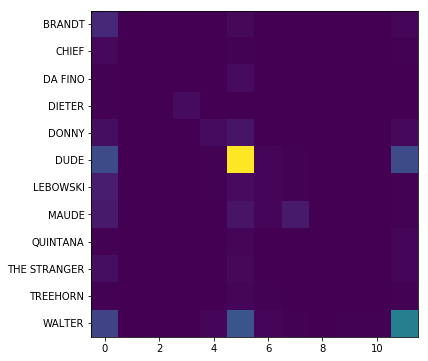

In [104]:
plt.rcParams['figure.figsize'] = 6,6
plt.imshow(confmat);
plt.yticks(range(len(one_hot.categories_[0])), one_hot.categories_[0]);

In [105]:
data['character'].value_counts()/len(data)

DUDE            0.445175
WALTER          0.282895
MAUDE           0.066886
LEBOWSKI        0.048246
BRANDT          0.044956
DONNY           0.044956
THE STRANGER    0.019737
TREEHORN        0.012061
DIETER          0.010965
DA FINO         0.009868
CHIEF           0.007675
QUINTANA        0.006579
Name: character, dtype: float64

> You's be better off just always predicting 'DUDE'

### Dude / UnDude

In [118]:
model = SVC(gamma='scale')
model = MLPClassifier()
pp = StandardScaler() # None # PCA(n_components=0.95)
accuracies = []
single_confmat = None

splits = StratifiedShuffleSplit(n_splits=10)
for train_idx, test_idx in splits.split(X, Y):
    
    if pp:
        X_train = pp.fit_transform(X[train_idx])
        X_test = pp.transform(X[test_idx])
    else:
        X_train = X[train_idx]
        X_test = X[test_idx]
    
    model.fit(X_train, data['undude'][train_idx])
    P = model.predict(X_test)
    T = data['undude'][test_idx]
    accuracies.append(accuracy_score(T, P))

    cm = confusion_matrix(T, P)
    single_confmat = cm if single_confmat is None else cm+single_confmat

print(np.mean(accuracies), np.std(accuracies))
print(single_confmat)

/Users/ivoeverts/miniconda3/envs/textenc2/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7076086956521739 0.044139001096189026
[[283 127]
 [142 368]]
